In [2]:
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import collections, colors, transforms
from pprint import pprint
import statistics
from datetime import datetime
import os
import random

In [3]:
import sys
sys.path
!pip install fpdf
import os, sys
from fpdf import FPDF, HTMLMixin

In [4]:
## class for extracting the repo is written here!

class Analyser:
    
    def __init__(self,repo,user):
        self.repo = repo
        self.user = user
        self.repofile = f'{repo}_users_repo_complete_data.json'
        print(self.repo,self.user,self.repofile)
    
    def getMainUser(self,filename):
        
        userData = self.getFileData(filename)
        
        for userdetails in userData.values():
            return userdetails['login']
    
    def getMainRepo(self):
        
        userData = self.getFileData(f"{self.repo}_main_data.json")
        
        userData["tagstring"] = ""
        
        if len(userData['tags']) == 0:
            userData["tagstring"] = "None"
        else:
            for tag in userData['tags'][:-1]:
                userData["tagstring"] += tag + ", "
            userData["tagstring"] += userData['tags'][-1]
        
        return userData
    
    def getFileData(self,filename = ""):
        RepoData = {}
        if filename == "":
            with open(f"ui/data/{self.repofile}",) as inpFile:
                RepoData = json.load(inpFile)
            return RepoData
        else:
            with open(f"ui/data/{filename}",) as inpFile:
                RepoData = json.load(inpFile)
            return RepoData
    
    def ContributorsChart(self,Z, filename):
        plt.figure(figsize=(20,3))
        plt.pcolormesh(Z, cmap='YlGn')
        plt.title('Contribution chart', fontweight ="bold")
        ax = plt.gca;
        days = ["Sat", "Fri", "Thur", "Wed", "Tues", "Mon", "Sun"];
        plt.yticks(np.arange(0.5, 7.5, step=1), days)
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()
        
    def LanguageChart(self,results, category_names, filename):
        labels = list(results.keys())
        data = np.array(list(results.values()))
        data_cum = data.cumsum(axis=1)
        category_colors = plt.get_cmap('RdYlGn')(
          np.linspace(0.15, 0.85, data.shape[1]))

        fig, ax = plt.subplots(figsize=(10, 1))
        ax.invert_yaxis()
        ax.xaxis.set_visible(False)
        ax.set_xlim(0, np.sum(data, axis=1).max())

        for i, (colname, color) in enumerate(zip(category_names, category_colors)):
          widths = data[:, i]
          starts = data_cum[:, i] - widths
          ax.barh(labels, widths, left=starts, height=0.5,
                  label=colname, color=color)
          xcenters = starts + widths / 2

          r, g, b, _ = color
          text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
          for y, (x, c) in enumerate(zip(xcenters, widths)):
              ax.text(x, y, str(int(c)), ha='center', va='center',
                      color=text_color)
        ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
                loc='lower left', fontsize='small')
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)
        plt.close()
        return fig, ax
    
    def SplitChart (self,category_names, min_values, max_values, mean_values, xlabel, ylabel, filename):
        plt.grid(color='#F2F2F2', alpha=1, zorder=0)
        plt.plot(category_names, max_values, label = "Maximal average")
        plt.plot(category_names, min_values, label = "Minimal average")
        plt.plot(category_names, mean_values, label = "User average")
        plt.xlabel(xlabel, fontsize=13)
        plt.xticks(rotation=30)
        plt.ylabel(ylabel, fontsize=13)
        #plt.legend()
        plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()
    
    def ContributorsContributionGraph(self,filename = ""):
        np_contribution_data = []
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        #print(repoData)
        totalContributor = len(repoData)
        for userData in repoData.values():
            contribution_details = userData["contributions"]["data"]["user"]["contributionsCollection"]["contributionCalendar"]["weeks"]
            #pprint(contribution_details)
            
            contribution_data = []
            
            for weeklydict in contribution_details:
                weeklyContribution = []
                weeklyData = weeklydict['contributionDays']
                
                for dailydict in weeklyData:
                    weeklyContribution.append(dailydict['contributionCount'])
                
                while len(weeklyContribution) < 7:
                    weeklyContribution.append(0)
                
                contribution_data.append(weeklyContribution)
            temp = np.transpose(np.array(contribution_data)) 
            #print(temp)
            np_contribution_data.append(temp)
        
        avg_data = np.zeros((7,53),dtype = int)
        
        for data in np_contribution_data:
            avg_data = avg_data.__add__(data)
        
        avg_data = np.true_divide(avg_data,totalContributor)
        if filename == "":
            self.ContributorsChart(avg_data,"contrichart")
        else:
            self.ContributorsChart(avg_data,"usercontrichart")
    
    def languageData(self):
        repoData = self.getFileData(f"{self.repo}_main_data.json")
        
        repo_languages = repoData['languages']
        
        languagesList = []
        languagePerList = []
        totalLine = 0
        for key,value in repo_languages.items():
            languagesList.append(key)
            languagePerList.append(value)
            totalLine +=value
            
        languagePerList[:] = ["{0:.2f}".format(x / totalLine) for x in languagePerList]
        
        return (languagesList,languagePerList)
        
        
    def ContributerTypeData(self):
        
        data = self.getFileData()
        userTypeDict = {}
        userList = []
        userTypeList = []
        
        for user, userdata in data.items():
            
            if userdata["company"] is not None:
                if "Professional" not in userTypeDict.keys():
                    userTypeDict["Professional"] = 1
                else:
                    userTypeDict["Professional"] += 1
            else:
                if userdata['type'] not in userTypeDict.keys():
                    userTypeDict[userdata['type']] = 1
                else:
                    userTypeDict[userdata['type']] += 1
        print(userTypeDict)  
        total_accounts = 0
        for key,values in userTypeDict.items():
            userTypeList.append(key)
            userList.append(values)
            total_accounts += values
        
        userList[:] = ["{0:.2f}".format(x/total_accounts) for x in userList]
        return userTypeList, userList        
     
    def CommitsPerDayAvg(self,filename = ""):
        
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        
        totalContributor = len(repoData)
        commitsList = []
        for userData in repoData.values():
            total_days = 0
            commit = 0
            contribution_details = userData["contributions"]["data"]["user"]["contributionsCollection"]["contributionCalendar"]["weeks"]
            for weeklydict in contribution_details:
                for dailydict in weeklydict['contributionDays']:
                    total_days += 1
                    commit += (dailydict['contributionCount'])
            
            commitsList.append(commit/ total_days)
        
        if filename != "":
            return "{0:.2f}".format(statistics.mean(commitsList))
        
        commits_stdev = 0 if len(commitsList) <= 1 else statistics.stdev(commitsList)
        commits_mean = statistics.mean(commitsList)
        
        lower_limit = commits_mean - commits_stdev if commits_mean - commits_stdev > 0 else 0
        upper_limit = commits_mean + commits_stdev
        
        print(lower_limit,upper_limit)
        
        return "{0:.2f}".format(lower_limit), "{0:.2f}".format(upper_limit)
    
    def OpenSourceProjectCount(self,filename = ""):
        
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        
        totalContributor = len(repoData)
        projectCountList = []
        for userData in repoData.values():
            repos = len(userData['repos'].values())
            projectCountList.append(repos)
            print(repos)
        
        if filename != "":
            return "{0:.2f}".format(statistics.mean(projectCountList))
        
        project_stdev = statistics.stdev(projectCountList) if len(projectCountList) > 1 else 0
        project_mean = statistics.mean(projectCountList)
        
        lower_limit = project_mean - project_stdev if project_mean - project_stdev > 0 else 0
        upper_limit = project_mean + project_stdev
        
        print(lower_limit,upper_limit)
        
        return "{0:.2f}".format(lower_limit), "{0:.2f}".format(upper_limit)
    
    def UserPublicRepoCount(self,filename = ""):
        
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        
        totalContributor = len(repoData)
        projectCountList = []
        for userData in repoData.values():
            repos = userData['public_repos']
            projectCountList.append(repos)
            print(repos)
        
        if filename != "":
            return "{0:.2f}".format(statistics.mean(projectCountList))
        
        project_stdev = statistics.stdev(projectCountList) if len(projectCountList) > 1 else 0
        project_mean = statistics.mean(projectCountList)
        
        lower_limit = project_mean - project_stdev if project_mean - project_stdev > 0 else 0
        upper_limit = project_mean + project_stdev
        
        print(lower_limit,upper_limit)
        
        return "{0:.2f}".format(lower_limit), "{0:.2f}".format(upper_limit)        
     
    def AccountAge(self,filename = ""):
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        
        totalContributor = len(repoData)
        projectCountList = []
        today = datetime.utcnow().year
        for userData in repoData.values():
            date = int(userData['created_at'].split('-')[0])
            projectCountList.append(today - date)
            print(date)
        
        if filename != "":
            return "{0:.2f}".format(statistics.mean(projectCountList))
        
        project_stdev = statistics.stdev(projectCountList) if len(projectCountList) > 1 else 0
        project_mean = statistics.mean(projectCountList)
        
        lower_limit = project_mean - project_stdev if project_mean - project_stdev > 0 else 0
        upper_limit = project_mean + project_stdev
        
        print(lower_limit,upper_limit)
        
        return "{0:.2f}".format(lower_limit), "{0:.2f}".format(upper_limit)
    
    def FollowersCount(self,filename = ""):
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        totalContributor = len(repoData)
        projectCountList = []
        for userData in repoData.values():
            repos = userData['followers']
            projectCountList.append(repos)
        
        if filename != "":
            return "{0:.2f}".format(statistics.mean(projectCountList))
        
        project_stdev = statistics.stdev(projectCountList) if len(projectCountList) > 1 else 0
        project_mean = statistics.mean(projectCountList)
        
        lower_limit = project_mean - project_stdev if project_mean - project_stdev > 0 else 0
        upper_limit = project_mean + project_stdev
        
        print(lower_limit,upper_limit)
        
        return "{0:.2f}".format(lower_limit), "{0:.2f}".format(upper_limit)
     
    
    def getExtension(self,path):
        filename, file_extension = os.path.splitext(path)
        return file_extension
    
    def TypeClassfier(self,extension):
        
        if extension == '.ts':
            return "typescript"
        elif extension == '.md' or extension == '.txt':
            return "documentation"
        elif extension == '.cpp' or extension == 'cxx':
            return "c++"
        elif extension == '.c' or extension == '.h':
            return "c"
        elif extension == '.html':
            return "html"
        elif extension == '.js':
            return "javascript"
        elif extension == '.css':
            return "css"
        elif extension == '.py':
            return "python"
        elif extension == '.java':
            return "java"
        else:
            return "others"
    
    def sorted_lists(self, list1, list2):
        zipped_lists = zip(list1, list2)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        list1, list2 = [ list(tuple) for tuple in  tuples]
        list1.reverse()
        list2.reverse()
        return list1,list2
    
    def FileTypeAnalyser(self,filename = ""):
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        usersAvg_dict = {}
        total_users = len(repoData.keys())
        
        for userData in repoData.values():
            
            usersRepo = userData['repos']
            #pprint(usersRepo)
            repo_file_dict = {}
            total_user_repos = len(usersRepo.keys())
            for data in usersRepo.values():
                file_dict = {}
                commitData = data['commit_files']
                total_files = len(commitData)
                if total_files == 0:
                    total_user_repos -= 1
                    continue
                
                for commit in commitData:
                    extension = self.getExtension(commit['filename'])
                    #print(extension)
                    filetype = self.TypeClassfier(extension)
                    
                    if filetype not in file_dict.keys():
                        file_dict[filetype] = 1
                    else:
                        file_dict[filetype] += 1
                t2 = 0
                for key,values in file_dict.items():
                    file_dict[key] = values/ total_files
                    t2 += file_dict[key]
                    if key not in repo_file_dict.keys():
                        repo_file_dict[key] = file_dict[key]
                    else:
                        repo_file_dict[key] += file_dict[key]
            t1 = 0    
            for key,values in repo_file_dict.items():    
                repo_file_dict[key] = values/ total_user_repos
                t1 += repo_file_dict[key]
                if key not in usersAvg_dict.keys():
                    usersAvg_dict[key] = repo_file_dict[key]
                else:
                    usersAvg_dict[key] += repo_file_dict[key]
    
        total = 0
        fileNameList = []
        filePercentList = []
        for key,value in usersAvg_dict.items():
            usersAvg_dict[key] = value/total_users
            total += usersAvg_dict[key]
            
            fileNameList.append(key)
            filePercentList.append("{0:.2f}".format(usersAvg_dict[key]))
        
        return self.sorted_lists(filePercentList,fileNameList)
        
    def makeLanguageCharts(self,filename):
        
        userData = self.getFileData(filename)
        userName = ""
        for key in userData.keys():
            userName = key
            
        userPercentList,userFileList = self.FileTypeAnalyser(filename)
        RepoPercentList,RepoListList = self.FileTypeAnalyser()
        MainRepoListList,MainRepoPercentList = self.languageData()
        MainRepoPercentList =  [int(float(x)*100) for x in MainRepoPercentList]
        userPercentList[:] = [int(float(x)*100) for x in userPercentList]
        RepoPercentList[:] = [int(float(x)*100) for x in RepoPercentList]
        self.LanguageChart({f'{self.user}/{self.repo}': MainRepoPercentList},MainRepoListList,"language")
        self.LanguageChart({f'{self.user}/{self.repo}': RepoPercentList},RepoListList,"RepoLanguage")
        self.LanguageChart({f'{userName}': userPercentList},userFileList,"UserLanguage")
        
        userTypeList, userList = self.ContributerTypeData()
        userList[:] = [int(float(x)) for x in userList]
        
        self.LanguageChart({f'User Type': userList},userTypeList,"ContributorType")
        
    
    def detailedGraph(self,filename):
        
        category_names = ['Commits per day', 'Open source projects',
                    'Public repositories', 'Account age', 'Followers']
        min_values = []
        max_values = []
        user_values = []
        temp_max = 0
        for category in category_names:
            min = 0
            max = 0
            user_data = 0
            if category == 'Commits per day':
                min,max = self.CommitsPerDayAvg()
                user_data = self.CommitsPerDayAvg(filename)
            if category == 'Open source projects':
                min,max = self.OpenSourceProjectCount()
                user_data = self.OpenSourceProjectCount(filename)
                
            if category == 'Public repositories':
                min,max = self.UserPublicRepoCount()
                user_data = self.UserPublicRepoCount(filename)
                
            if category == 'Account age':
                min,max = self.AccountAge()
                user_data = self.AccountAge(filename)
                
            if category == 'Followers':
                min,max = self.FollowersCount()
                user_data = self.FollowersCount(filename)
            print(min,max,user_data)
            min = float(min)
            max = float(max)
            user_data = float(user_data)
            
            print(min,max,user_data)
            temp_max = (max + ((random.randrange(2,4))/10 * max)) if max > user_data else user_data
            temp_max = temp_max/10
            min_values.append((min*100)/temp_max)
            max_values.append((max*100)/temp_max)
            user_values.append((user_data*100)/temp_max)
        print("values are: \n")
        print(min_values,max_values,user_values)
        self.SplitChart(category_names, min_values, max_values, user_values, "Languages", "Usage", "samplechart")       


SE-gamedev arpit1912 SE-gamedev_users_repo_complete_data.json


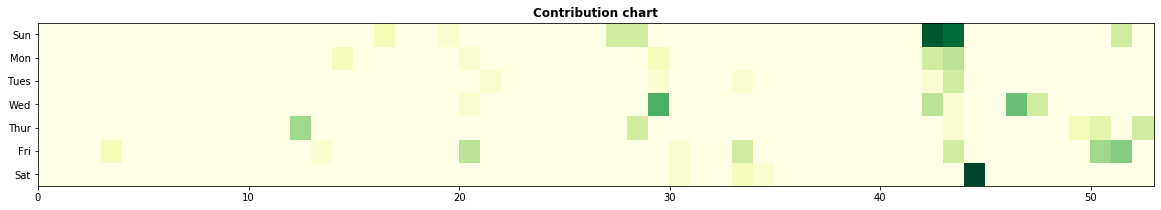

{'User': 1}
0.43989071038251365 0.43989071038251365
commits  ('0.44', '0.44')
5
5 5
Open Source  ('5.00', '5.00')
7
7 7
Public Repo  ('7.00', '7.00')
2019
2 2
Account age  ('2.00', '2.00')
0 0
Follower Count  ('0.00', '0.00')
 File analysis  (['0.67', '0.20', '0.07', '0.03', '0.02', '0.01'], ['others', 'javascript', 'python', 'css', 'documentation', 'html'])

user's data here



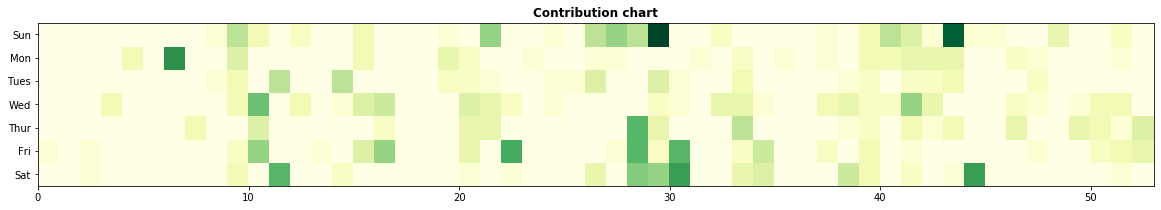

user name is  arpit1912
user's commits  1.58
2
user's Open Source  2.00
21
user's Public Repo  21.00
2019
user's Account age  2.00
user's Follower Count  6.00
user's File analysis  (['0.46', '0.24', '0.13', '0.07', '0.07', '0.03'], ['typescript', 'others', 'javascript', 'java', 'documentation', 'html'])
{'User': 1}
0.43989071038251365 0.43989071038251365
0.44 0.44 1.58
0.44 0.44 1.58
5
5 5
2
5.00 5.00 2.00
5.0 5.0 2.0
7
7 7
21
7.00 7.00 21.00
7.0 7.0 21.0
2019
2 2
2019
2.00 2.00 2.00
2.0 2.0 2.0
0 0
0.00 0.00 6.00
0.0 0.0 6.0
values are: 

[278.4810126582278, 833.3333333333334, 333.3333333333333, 1000.0, 0.0] [278.4810126582278, 833.3333333333334, 333.3333333333333, 1000.0, 0.0] [1000.0, 333.33333333333337, 1000.0, 1000.0, 1000.0]


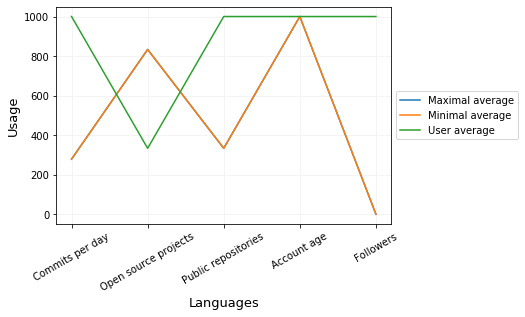

In [5]:
analyser = Analyser("SE-gamedev","arpit1912")
analyser.ContributorsContributionGraph()
analyser.ContributerTypeData()
print("commits ",analyser.CommitsPerDayAvg())
print("Open Source ",analyser.OpenSourceProjectCount())
print("Public Repo ",analyser.UserPublicRepoCount())
print("Account age ",analyser.AccountAge())
print("Follower Count ",analyser.FollowersCount())
print(" File analysis ",analyser.FileTypeAnalyser())
#analyser.FileTypeAnalyser()

print("\nuser's data here\n")

analyser.ContributorsContributionGraph("user_complete_data.json")
analyser.getMainRepo()
print('user name is ',analyser.getMainUser("user_complete_data.json"))
print("user's commits ",analyser.CommitsPerDayAvg("user_complete_data.json"))
print("user's Open Source ",analyser.OpenSourceProjectCount("user_complete_data.json"))
print("user's Public Repo ",analyser.UserPublicRepoCount("user_complete_data.json"))
print("user's Account age ",analyser.AccountAge("user_complete_data.json"))
print("user's Follower Count ",analyser.FollowersCount("user_complete_data.json"))
print("user's File analysis ",analyser.FileTypeAnalyser("user_complete_data.json"))
analyser.makeLanguageCharts("user_complete_data.json")
analyser.detailedGraph("user_complete_data.json")

arpit1912/SE-gamedev
0 0
0.43989071038251365 0.43989071038251365
5
5 5
7
7 7
2019
2 2
0 0

user's data here



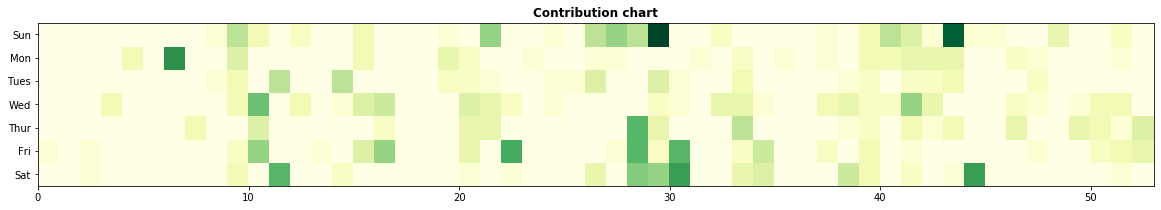

2
21
2019


In [6]:
images = ['contrichart.png' , 'language.png' , 'samplechart.png']
print(analyser.user + '/' + analyser.repo)
reponame = analyser.user + '/' + analyser.repo
username = analyser.getMainUser("user_complete_data.json")
repolink = "https://github.com/" + analyser.user + '/' + analyser.repo 
mainRepoData = analyser.getMainRepo()
repo_about = mainRepoData["description"]
repo_tags = mainRepoData["tagstring"] 
repo_doc = mainRepoData["created_at"].split('T')[0]
repo_contricount = str(mainRepoData["total_contributors"])
repo_lastcommitdate = mainRepoData["updated_at"].split('T')[0]
repo_openissuecount = str(mainRepoData['open_issues_count'])
repo_starscount = f"{mainRepoData['watchers_count']}"
repo_forkscount = f"{mainRepoData['forks_count']}"
print(repo_openissuecount,repo_starscount )
repo_activescore = "3.5"
repo_languagepercent,repo_languagename = analyser.FileTypeAnalyser()

#new repo variables added on 08-01-2021

repo_cmin_commitperday,repo_cmax_commitperday = analyser.CommitsPerDayAvg()
repo_cmin_oscount,repo_cmax_oscount = analyser.OpenSourceProjectCount()
repo_cmin_publicrepocount,repo_cmax_publicrepocount = analyser.UserPublicRepoCount()
repo_cmin_accountage,repo_cmax_accountage = analyser.AccountAge()
repo_cmin_followers,repo_cmax_followers = analyser.FollowersCount()

repo_c_commitperday = "{0:.2f}".format( (float(repo_cmin_commitperday) + float(repo_cmax_commitperday)) / 2)


# language Data will give a tuple of above two list

user_activescore = "2.5"
user_languagepercent,user_languagename = analyser.FileTypeAnalyser("user_complete_data.json")

#new user variables added on 08-01-2021 

print("\nuser's data here\n")

analyser.ContributorsContributionGraph("user_complete_data.json")

user_commitperday = (analyser.CommitsPerDayAvg("user_complete_data.json"))
user_oscount = (analyser.OpenSourceProjectCount("user_complete_data.json"))
user_publicrepocount = (analyser.UserPublicRepoCount("user_complete_data.json"))
user_accountage = (analyser.AccountAge("user_complete_data.json"))
user_followers = (analyser.FollowersCount("user_complete_data.json"))

In [7]:
class PDF(FPDF, HTMLMixin):
    def __init__(self):
        super().__init__()
        self.WIDTH = 210
        self.HEIGHT = 297
        
    def lines(self):
        self.rect(5.0, 5.0, 200.0,287.0)
        
    def header(self):
        # Custom logo and positioning
        # Create an `assets` folder and put any wide and short image inside
        # Name the image `logo.png`
        #self.image('assets/logo.png', 10, 8, 33)
        self.set_font('Arial', 'B', 11)
        self.cell(self.WIDTH - 80)
        self.cell(60, 1, 'RepoSummariser', 0, 0, 'R')
        self.ln(20)
        
    def footer(self):
        # Page numbers in the footer
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.set_text_color(128)
        self.cell(0, 10, 'Page ' + str(self.page_no()), 0, 0, 'C')

    def page_body(self, images):
        # Determine how many plots there are per page and set positions
        # and margins accordingly
        '''
        if len(images) == 3:
            self.image(images[0], 15, 25, self.WIDTH - 30)
            self.image(images[1], 15, self.WIDTH / 2 + 5, self.WIDTH - 30)
            self.image(images[2], 15, self.WIDTH / 2 + 90, self.WIDTH - 30)
        elif len(images) == 2:
            self.image(images[0], 15, 25, self.WIDTH - 30)
            self.image(images[1], 15, self.WIDTH / 2 + 5, self.WIDTH - 30)
        else:
            self.image(images[0], 15, 25, self.WIDTH - 30)
        
        '''
        self.add_page()
        self.lines()
        #page 1 : general main repo stats, user stats
        
        self.set_xy(10.0,17.0)
        self.set_font('Arial', 'B', 18)
        self.set_text_color(186, 80, 100)
        #self.write_html("Analysis of repository + <b> reponame </b>")
        self.multi_cell(w=0, h=14.0, align='C', txt="Analysis of repository "+  reponame  + " and userID " + username, border="")
        
        self.set_xy(10.0,self.get_y() + 2)
        self.set_font('Arial', 'B', 16)
        self.set_text_color(186, 80, 100)
        self.cell(w=0.0, h=10.0, align='L', txt= reponame + " details" , border="T", link=repolink)
        
        self.set_xy(14.0,self.get_y()+10)
        self.set_font('Arial', 'B', 14)
        self.set_text_color(0, 0, 0)
        self.cell(w=18.0, h=9.0, align='L', txt= "About: ", border=0)
        
        self.set_xy(self.get_x(), self.get_y())
        self.set_font('Arial', '', 14)
        self.multi_cell(w=0.0, h=9.0, align='L', txt= repo_about, border=0)
        
        self.set_xy(14, self.get_y())
        self.set_font('Arial', 'B', 14)
        self.cell(w=32.0, h=9.0, align='L', txt= "Project tags: ", border=0)
        
        self.set_xy(self.get_x(), self.get_y())
        self.set_font('Arial', '', 14)
        self.multi_cell(w=0.0, h=9.0, align='L', txt= repo_tags, border=0)
        
        self.set_xy(14.0,self.get_y())
        self.set_font('Arial', 'B', 14)
        self.multi_cell(w=0.0, h=8.0, align='L', txt= "Project stats: ", border=0)
        
        self.set_xy(22.0,self.get_y())
        self.set_font('Arial', '', 13)
        self.multi_cell(w=0.0, h=6.0, align='L', txt= "Project Status: Active (last commit on "+repo_lastcommitdate+")\n" +
                        "Date of creation: " + repo_doc + "\n" +
                        "Contributors: " + repo_contricount + "\n" +
                        "Commits: " + repo_contricount + "\n" +
                        "Forks: " + repo_forkscount + "\n" +
                        "Stars: " + repo_starscount + "\n" +
                        "Open issues: " + repo_openissuecount + "\n", border=0)
        
        #repository language split
        self.set_xy(14.0,self.get_y()+5)
        self.set_font('Arial', 'B', 14)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=0.0, h=9.0, align='L', txt= "Languages: \n", border=0)
        self.image('language.png', 18.0, self.get_y() + 2.0, self.WIDTH - 40, 15)
        
        #types of contributors accounts
        self.set_xy(14.0,self.get_y() + 25)
        self.set_font('Arial', 'B', 14)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=0.0, h=9.0, align='L', txt= "Contributor account types: \n", border=0)
        self.image('ContributorType.png', 18.0, self.get_y() + 2.0, self.WIDTH - 40, 15)
        
        
        
        #page 2 : report start with activeness score user and repo, contine
        #decide what text stas to add, charts etc
        
        self.add_page()
        self.lines()
        
        self.set_xy(10.0,15.0)
        self.set_font('Arial', 'B', 22)
        self.set_text_color(186, 80, 100)
        self.cell(w=0, h=15.0, align='C', txt="Analysis report", border="B")
        
        self.set_xy(10.0,45.0)
        self.set_font('Arial', 'B', 20)
        self.cell(w=0.0, h=0.0, align='L', txt= "Activeness score:" , border=0)
        
        self.set_xy(76.0,41.0)
        self.set_font('Arial', 'B', 14)
        self.set_text_color(0, 0, 0)
        self.cell(w=0.0, h=0.0, align='L', txt= username + ": " + user_activescore, border=0)
        
        self.set_xy(76.0,49.0)
        self.cell(w=0.0, h=0.0, align='L', txt= reponame + " contributors (avg): " + repo_activescore, border=0)
        
        self.set_xy(10.0,self.get_y() + 15)
        self.set_font('Arial', 'B', 20)
        self.set_text_color(186, 80, 100)
        self.cell(w=0.0, h=0.0, align='L', txt= "Detailed comparison:" , border=0)
        
        height_y = self.get_y()+12
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', 'B', 10)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=7.0, align='C', txt= reponame + " contributors minimal average", border="R")
        
        self.set_font('Arial', 'B', 12)
        self.set_xy(115.0,height_y)
        self.cell(w=30.0, h=7.0, align='C', txt= username, border="")
        
        self.set_font('Arial', 'B', 10)
        self.set_xy(145.0,height_y)
        self.multi_cell(w=55.0, h=7.0, align='C', txt= reponame + " contributors maximal average", border="L")
        
        #commits per day
        height_y = self.get_y()
        
        self.set_xy(5.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=50.0, h=9.0, align='C', txt= "Commits per day", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= repo_cmin_commitperday, border="R")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=30.0, h=9.0, align='C', txt= user_commitperday, border="")
        
        self.set_xy(145.0,height_y)
        self.multi_cell(w=55.0, h=9.0, align='C', txt= repo_cmax_commitperday, border="L")
        
        #Open source projects contributed to
        height_y = self.get_y()
        
        self.set_xy(5.0,height_y)
        self.set_font('Arial', 'B', 10)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=50.0, h=9.0, align='C', txt= "Open source projects count", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= repo_cmin_oscount, border="R")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=30.0, h=9.0, align='C', txt= user_oscount, border="")
        
        self.set_xy(145.0,height_y)
        self.multi_cell(w=55.0, h=9.0, align='C', txt= repo_cmax_oscount, border="L")
        
        #Public repositories
        height_y = self.get_y()
        
        self.set_xy(5.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=50.0, h=9.0, align='C', txt= "Public repositories", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= repo_cmin_publicrepocount, border="R")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=30.0, h=9.0, align='C', txt= user_publicrepocount, border="")
        
        self.set_xy(145.0,height_y)
        self.multi_cell(w=55.0, h=9.0, align='C', txt= repo_cmax_publicrepocount, border="L")
        
        #Account age
        height_y = self.get_y()
        
        self.set_xy(5.0,height_y)
        self.set_font('Arial', 'B', 11)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=50.0, h=9.0, align='C', txt= "Account age (yrs)", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= repo_cmin_accountage, border="R")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=30.0, h=9.0, align='C', txt= user_accountage, border="")
        
        self.set_xy(145.0,height_y)
        self.multi_cell(w=55.0, h=9.0, align='C', txt= repo_cmax_accountage, border="L")
        
        #Followers
        height_y = self.get_y()
        
        self.set_xy(5.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=50.0, h=9.0, align='C', txt= "Followers", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= repo_cmin_followers, border="R")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=30.0, h=9.0, align='C', txt= user_followers, border="")
        
        self.set_xy(145.0,height_y)
        self.multi_cell(w=55.0, h=9.0, align='C', txt= repo_cmax_followers, border="L")
        
        #add more if needed
        #chart plotting these parametera
        
        self.image('samplechart.png', 12.0, self.get_y() + 10.0, self.WIDTH - 20)
        
        self.set_xy(10.0,265)
        self.set_font('Arial', 'I', 8)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=0.0, h=8.0, align='L', txt= "*Minimal average corresponds to (mean - std dev) while maximal average corresponds to (mean + std dev). 68% of contributors lie within this range", border="")
        
        #page 3 : language split and avg contribution chart
        
        self.add_page()
        self.lines()
        
        self.set_xy(10.0,15.0)
        self.set_font('Arial', 'B', 20)
        self.set_text_color(186, 80, 100)
        self.cell(w=0, h=15.0, align='L', txt="Language usage", border="B")
        
        height_y = self.get_y() + 20
        self.set_xy(15.0,height_y)
        self.set_font('Arial', 'B', 16)
        self.cell(w=0, h=10.0, align='C', txt="Top 5 preferred languages", border="B")
        height_y = self.get_y() + 15
        
        self.set_xy(10.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=45.0, h=9.0, align='C', txt= "Preference order", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= username, border="LR")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=80.0, h=9.0, align='C', txt= reponame + " contributors (average)", border="LR")
        
        #language 1
        height_y = self.get_y()
        self.set_xy(10.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=45.0, h=9.0, align='C', txt= "1.", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= user_languagename[0] + " - "+ user_languagepercent[0], border="R")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=80.0, h=9.0, align='C', txt= repo_languagename[0] + " - "+ repo_languagepercent[0], border="LR")
        
        #language 2
        height_y = self.get_y()
        self.set_xy(10.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=45.0, h=9.0, align='C', txt= "2.", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= user_languagename[1] + " - "+ user_languagepercent[1], border="R")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=80.0, h=9.0, align='C', txt= repo_languagename[1] + " - "+ repo_languagepercent[1], border="LR")
        
        #language 3
        height_y = self.get_y()
        self.set_xy(10.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=45.0, h=9.0, align='C', txt= "3.", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= user_languagename[2] + " - "+ user_languagepercent[2], border="R")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=80.0, h=9.0, align='C', txt= repo_languagename[2] + " - "+ repo_languagepercent[2], border="LR")
        
        #language 4
        height_y = self.get_y()
        self.set_xy(10.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=45.0, h=9.0, align='C', txt= "4.", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= user_languagename[3] + " - "+ user_languagepercent[3], border="R")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=80.0, h=9.0, align='C', txt= repo_languagename[3] + " - "+ repo_languagepercent[3], border="LR")
        
        #language 5
        height_y = self.get_y()
        self.set_xy(10.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=45.0, h=9.0, align='C', txt= "5.", border="R")
        
        self.set_xy(55.0,height_y)
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=60.0, h=9.0, align='C', txt= user_languagename[4] + " - "+ user_languagepercent[4], border="R")
            
        self.set_xy(115.0,height_y)
        self.multi_cell(w=80.0, h=9.0, align='C', txt= repo_languagename[4] + " - "+ repo_languagepercent[4], border="LR")
        
        #user language chart
        self.set_xy(14.0,self.get_y()+10)
        self.set_font('Arial', 'B', 14)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=0.0, h=9.0, align='L', txt=username + " languages: \n", border=0)
        self.image('UserLanguage.png', 18.0, self.get_y() + 2.0, self.WIDTH - 40, 15)
        
        #contributor language chart
        self.set_xy(14.0,self.get_y() + 25)
        self.set_font('Arial', 'B', 14)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=0.0, h=9.0, align='L', txt= reponame + " contributors languages\n", border=0)
        self.image('RepoLanguage.png', 18.0, self.get_y() + 2.0, self.WIDTH - 40, 15)
        
        self.set_xy(10.0,260)
        self.set_font('Arial', 'I', 10)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=0.0, h=8.0, align='L', txt= "*Others includes all languages excluding C, C++, JAVA, Python, JS, markdown, text, HTML, typescript and css", border="")
        
        
        #page 4 : language split and avg contribution chart
        
        self.add_page()
        self.lines()
        
        self.set_xy(10.0,15.0)
        self.set_font('Arial', 'B', 20)
        self.set_text_color(186, 80, 100)
        self.cell(w=0, h=15.0, align='L', txt="Past year contributions", border="B")
        
        #user daily contribution
        height_y = self.get_y() + 20
        self.set_xy(15.0,height_y)
        self.set_font('Arial', 'B', 15)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=0, h=10.0, align='C', txt="Average commits per day ("+username+") = " + user_commitperday , border="")
        
        self.image('usercontrichart.png', 18.0, self.get_y() + 2.0, self.WIDTH - 40)
        
        height_y = self.get_y() + 40
        self.set_xy(15.0,height_y)
        self.set_font('Arial', 'B', 15)
        self.set_text_color(0, 0, 0)
        self.multi_cell(w=0, h=10.0, align='C', txt="Average commits per day ("+reponame+" contributors) = " + repo_c_commitperday , border="")
        
        self.image('contrichart.png', 18.0, self.get_y() + 2.0, self.WIDTH - 40)
        
        height_y = self.get_y() + 40
        self.set_xy(15.0,height_y)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(186, 80, 100)
        self.multi_cell(w=0, h=10.0, align='L', txt="Information about activeness score" , border="")
        
    def print_page(self, images):
        # Generates the report
        self.page_body(images)

In [8]:
pdf = PDF()

pdf.print_page(images)
    
pdf.output('test1.pdf', 'F')

''